## Objective
This notebook tests whether baseline subgenual anterior cingulate cortex (sgACC) functional connectivity (FC) differs across sham and active tFUS sessions and whether stimulation drives condition-specific changes over time. The analysis focuses on sgACC-to-whole-brain edges extracted from the DiFuMo 1024 atlas and produces both statistical summaries and publication-ready plots.

### Generated Artifacts
- `statsmodels` mixed-effects output that quantifies main effects for time, condition, and their interaction.
- A tidy table of fitted means stored in-memory (`pred_grid`) for quick inspection or downstream export.
- The figure `../figures/fc_change_vs_fc_baseline_violin_plot.png`, which is referenced in the manuscript Results section.

### Data Dependencies and Inputs
- `../data/precomputed/df_fc.pkl`: tidy table containing the columns `subject`, `condition`, `time_window`, `fc`, `roi1`, and `roi2`. Each row corresponds to a pairwise FC estimate between atlas parcels.
- DiFuMo 1024 atlas downloaded through `nilearn.datasets.fetch_atlas_difumo`. The downloader caches files under `~/nilearn_data`, so no additional files need to be tracked in the repository.
- Output paths assume the default project tree (`../figures/` relative to this notebook). Adjust the paths if you mirror the analysis outside of this repository.

### Execution Workflow
1. Import common neuroimaging and statistics packages (NumPy, pandas, Nilearn, StatsModels, Matplotlib, and Seaborn).
2. Load the pre-computed FC dataframe and identify sgACC parcels via the DiFuMo atlas labels.
3. Flag and subset all sgACC-containing edges, then collapse them into subject-level mean FC values for each condition and time window.
4. Fit a linear mixed-effects model with a subject-level random intercept to capture differences attributable to stimulation condition, time, and their interaction.
5. Build a tidy prediction grid for quick effect-size inspection.
6. Visualize sham vs. active trajectories with paired violin/strip plots and save the resulting figure for manuscript use.

### Reproducibility and Sharing Notes
- Activate the project environment (`conda activate fus-bold` or equivalent) before executing the notebook so that StatsModels, Nilearn, and plotting libraries are available.
- Confirm that `../data/precomputed/df_fc.pkl` reflects the finalized preprocessing pipeline; regenerate the pickle if upstream scripts change any column names or filtering rules.
- When re-running in continuous integration or headless environments, use `jupyter nbconvert --to notebook --execute code/analyze_fc_change_vs_fc_baseline.ipynb` to capture cell outputs and verify that the saved figure refreshes.
- The notebook is deterministic apart from Seaborn's strip-plot jitter; set `np.random.seed(...)` at the top if you need identical point placements across renders.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)

In [3]:
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
#atlas_img = nib.load(difumo.maps)
subgenual = df_labels.loc[133,'difumo_names']
subgenual

'Subgenual cortex'

In [4]:
df["is_roi1_subgenual"] = df["roi1"] == subgenual
df["is_roi2_subgenual"] = df["roi2"] == subgenual
df["is_pair_subgenual"] = df["is_roi1_subgenual"] | df["is_roi2_subgenual"]
df["is_pair_subgenual"].sum()

np.int64(98208)

In [5]:
df_sg = df[df["is_pair_subgenual"]].copy()
df_sg["roi_pair"] = ["__".join(sorted((r1, r2))) for r1, r2 in zip(df_sg["roi1"], df_sg["roi2"])]

## Mixed Effects Model\nWe treat subject-level mean sgACC FC (`fc`) as the dependent variable and model it as a function of time window (`pre`, `fus`, `post`) and stimulation condition (`sham`, `active`). The formula implemented in `statsmodels.mixedlm` is:\n\n```\nfc ~ C(time_window, Treatment(reference='pre')) * C(condition, Treatment(reference='sham'))\n```\n\nKey features:\n- **Random intercept per subject**: accounts for baseline differences and repeated-measures structure.\n- **Treatment coding**: estimates interpretable contrasts relative to the pre-sham baseline.\n- **Interaction term**: tests whether active stimulation alters FC trajectories beyond any sham-related drift.\n\nUse the printed summary to extract coefficient estimates, 95\% confidence intervals, and p-values for the manuscript text and to contextualize the annotations that appear on the violin plot.

In [6]:
# --------------------------------------------------------------------
# 0. Create working dataframe and remove unnecessary columns
#   Assumes df_sg has columns: subject, condition, time_window, fc
# --------------------------------------------------------------------
dfw = df_sg.copy().drop(columns=["roi1", "roi2", "is_roi1_subgenual", "is_roi2_subgenual", "is_pair_subgenual","roi_pair"]).reset_index(drop=True)

# --------------------------------------------------------------------
# 1. Subject-level means (avoids treating edges as independent)
#    Assumes dfw has columns: subject, condition, time_window, fc
# --------------------------------------------------------------------
dfw_mu = (
    dfw
    .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
    .mean()
)

# --------------------------------------------------------------------
# 2. Categorical coding with explicit reference levels
#    Make sure the categories match your actual labels:
#    use ["pre", "stim", "post"] if that's what you used instead of "fus"
# --------------------------------------------------------------------
dfw_mu["time_window"] = pd.Categorical(
    dfw_mu["time_window"],
    categories=["pre", "fus", "post"],
    ordered=False
)

dfw_mu["condition"] = pd.Categorical(
    dfw_mu["condition"],
    categories=["sham", "active"],
    ordered=False
)

# --------------------------------------------------------------------
# 3. Mixed-effects model:
#    fc ~ time_window * condition
#    - Reference: sham at pre
#    - Random intercept: subject
# --------------------------------------------------------------------
model = smf.mixedlm(
    "fc ~ C(time_window, Treatment(reference='pre')) "
    "* C(condition, Treatment(reference='sham'))",
    dfw_mu,
    groups=dfw_mu["subject"],
    re_formula="1",
    missing="drop"
)

result = model.fit(method="lbfgs", reml=True)
print(result.summary())

# --------------------------------------------------------------------
# 4. (Optional) Extract cell means for plotting / sanity check
# --------------------------------------------------------------------
# Build a small table of fitted means by condition × time_window
pred_grid = (
    dfw_mu[["condition", "time_window"]]
    .drop_duplicates()
    .sort_values(["condition", "time_window"])
)

pred_grid["fc_pred"] = result.predict(pred_grid)
print("\nFitted means by condition × time_window:")
print(pred_grid)

                                                      Mixed Linear Model Regression Results
Model:                                            MixedLM                               Dependent Variable:                               fc     
No. Observations:                                 96                                    Method:                                           REML   
No. Groups:                                       16                                    Scale:                                            0.0055 
Min. group size:                                  6                                     Log-Likelihood:                                   91.7147
Max. group size:                                  6                                     Converged:                                        Yes    
Mean group size:                                  6.0                                                                                            
--------------------------------

/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Violin Plot Figure
The final visualization pairs violin plots with subject-level trajectories to illustrate how sgACC FC evolves across `pre`, `tFUS`, and `post` windows for each condition. Sham and active panels share the same y-axis limits to ease comparison, and textual annotations call out the key statistical results from the mixed model (baseline offsets and post-stimulation differences). The plot is exported to `../figures/fc_change_vs_fc_baseline_violin_plot.png` at 300 DPI so it can be version-controlled and imported directly into the manuscript's Results figure. Re-run the last cell after updating the dataframe to refresh the figure on disk.

<>:180: SyntaxWarning: invalid escape sequence '\D'
<>:180: SyntaxWarning: invalid escape sequence '\D'
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_87737/2418378689.py:180: SyntaxWarning: invalid escape sequence '\D'
  "Pre→post $\Delta$ active > sham\n($p=0.033$)",
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_87737/2418378689.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Pre", "tFUS", "Post"])
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_87737/2418378689.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Pre", "tFUS", "Post"])


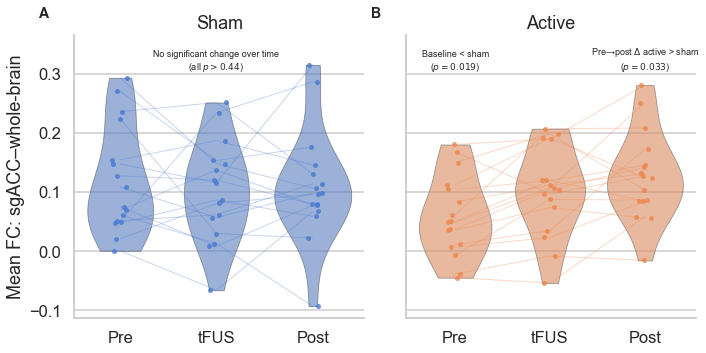

In [7]:
# ---------------------------------------------------------------------
# Assumes dfw has columns: subject, condition, time_window, fc
# and time_window labels: "pre", "fus", "post"
# ---------------------------------------------------------------------

# 1. Subject-level means (same aggregation as mixed model)
dfw_mu = (
    dfw
    .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
    .mean()
)

time_order = ["pre", "fus", "post"]
cond_order = ["sham", "active"]

dfw_mu["time_window"] = pd.Categorical(
    dfw_mu["time_window"],
    categories=time_order,
    ordered=True
)
dfw_mu["condition"] = pd.Categorical(
    dfw_mu["condition"],
    categories=cond_order,
    ordered=False
)

# Helper: map time_window to x positions
time_idx = {t: i for i, t in enumerate(time_order)}

# ---------------------------------------------------------------------
# 2. Plot setup
# ---------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk")
palette = sns.color_palette("muted")
color_sham = palette[0]
color_active = palette[1]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# =========================
# (A) Sham: raw FC
# =========================
ax = axes[0]
data_sham = dfw_mu[dfw_mu["condition"] == "sham"]

sns.violinplot(
    data=data_sham,
    x="time_window",
    y="fc",
    order=time_order,
    inner=None,
    cut=0,
    linewidth=0.8,
    ax=ax,
    color=color_sham
)

# make violins slightly transparent
for c in ax.collections:
    c.set_alpha(0.6)

sns.stripplot(
    data=data_sham,
    x="time_window",
    y="fc",
    order=time_order,
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=5,
    ax=ax,
    color=color_sham
)

# connect each subject's trajectory (thin, subtle)
for subj, sdf in data_sham.groupby("subject"):
    sdf = sdf.sort_values("time_window")
    ax.plot(
        [time_idx[t] for t in sdf["time_window"]],
        sdf["fc"].values,
        alpha=0.3,
        linewidth=1,
        color=color_sham
    )

ax.set_xticklabels(["Pre", "tFUS", "Post"])
ax.set_title("Sham")
ax.set_xlabel("")
ax.set_ylabel("Mean FC: sgACC–whole-brain")
sns.despine(ax=ax)

# expand y-limit slightly to make room for text
ylims = ax.get_ylim()
ax.set_ylim((ylims[0], ylims[1] + 0.03))

# Annotate: no significant time effect
ymax_sham = data_sham["fc"].max()
ax.text(
    1,
    ymax_sham - 0.015,
    "No significant change over time\n(all $p>0.44$)",
    ha="center", va="bottom",
    fontsize=9
)

# Panel label (A)
ax.text(
    -0.12, 1.05, "A",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=14, fontweight="bold"
)

# =========================
# (B) Active: raw FC + key stats
# =========================
ax = axes[1]
data_active = dfw_mu[dfw_mu["condition"] == "active"]

sns.violinplot(
    data=data_active,
    x="time_window",
    y="fc",
    order=time_order,
    inner=None,
    cut=0,
    linewidth=0.8,
    ax=ax,
    color=color_active
)

for c in ax.collections:
    c.set_alpha(0.6)

sns.stripplot(
    data=data_active,
    x="time_window",
    y="fc",
    order=time_order,
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=5,
    ax=ax,
    color=color_active
)

for subj, sdf in data_active.groupby("subject"):
    sdf = sdf.sort_values("time_window")
    ax.plot(
        [time_idx[t] for t in sdf["time_window"]],
        sdf["fc"].values,
        alpha=0.3,
        linewidth=1,
        color=color_active
    )

ax.set_xticklabels(["Pre", "tFUS", "Post"])
ax.set_title("Active")
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(ax=ax)

ymax_act = data_active["fc"].max()

# Annotations based on mixed model:
# - Baseline difference: active < sham at pre (p = 0.019)
ax.text(
    time_idx["pre"],
    ymax_act + 0.02,
    "Baseline < sham\n($p=0.019$)",
    ha="center", va="bottom",
    fontsize=9
)

# - Pre→post difference-in-differences: active > sham (p = 0.033)
ax.text(
    time_idx["post"],
    ymax_act + 0.02,
    "Pre→post $\Delta$ active > sham\n($p=0.033$)",
    ha="center", va="bottom",
    fontsize=9
)

# Panel label (B)
ax.text(
    -0.12, 1.05, "B",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=14, fontweight="bold"
)

plt.tight_layout()

plt.savefig('../figures/fc_change_vs_fc_baseline_violin_plot.png', dpi=300)
plt.show()